<a href="https://colab.research.google.com/github/bksat90/FinalProject/blob/main/cnn_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Import and mount Google Drive.
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# # Unzip the dataset file and store it in a folder called images.
# !unzip "/content/drive/MyDrive/Project_BC/archive.zip" -d "/content/drive/MyDrive/Project_BC/cnn/"

In [6]:
label_dict = {'benign' : 0,
              'malignant' : 1}

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Project_BC/cnn/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "valid/*/*")

In [7]:
def img_process(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size=[320,320])
  image = image / 255.0
  return image, label

In [8]:
train_ds = train_list_ds
val_ds = valid_list_ds

# parsing and processing the training images
train_ds = (
    train_ds
    .shuffle(1000)
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(32)
    .cache()
)

# parsing and processing the validation images
val_ds = (
    val_ds
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(32)
    .cache()
)

In [9]:
base_model = tf.keras.applications.vgg19.VGG19(include_top=False,
                                               weights='imagenet',
                                               input_shape=(320, 320, 3),
                                               pooling='max')

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
base_model.trainable=False

80134624/80134624 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20155969 (76.89 MB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
checkpoint_filepath = '/content/checkpoint/'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [13]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = LearningRateScheduler(scheduler)

In [14]:
epoch_num = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch_num,
    callbacks=[checkpoint_callback, lr_callback]
)

Epoch 1/100
38/38 [==============================] - 519s 13s/step - loss: 0.6426 - accuracy: 0.6547 - val_loss: 0.6369 - val_accuracy: 0.6593 - lr: 5.0000e-05
Epoch 2/100
38/38 [==============================] - 26s 683ms/step - loss: 0.6348 - accuracy: 0.6577 - val_loss: 0.6339 - val_accuracy: 0.6563 - lr: 5.0000e-05
Epoch 3/100
38/38 [==============================] - 26s 696ms/step - loss: 0.6302 - accuracy: 0.6623 - val_loss: 0.6320 - val_accuracy: 0.6548 - lr: 5.0000e-05
Epoch 4/100
38/38 [==============================] - 27s 706ms/step - loss: 0.6264 - accuracy: 0.6644 - val_loss: 0.6304 - val_accuracy: 0.6563 - lr: 5.0000e-05
Epoch 5/100
38/38 [==============================] - 27s 717ms/step - loss: 0.6234 - accuracy: 0.6678 - val_loss: 0.6291 - val_accuracy: 0.6504 - lr: 5.0000e-05
Epoch 6/100
38/38 [==============================] - 27s 726ms/step - loss: 0.6207 - accuracy: 0.6678 - val_loss: 0.6278 - val_accuracy: 0.6504 - lr: 5.0000e-05
Epoch 7/100
38/38 [================

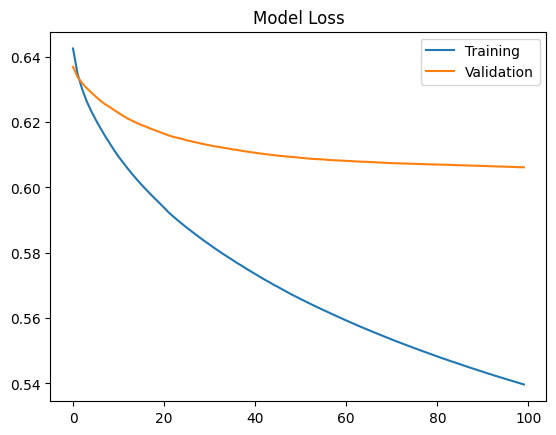

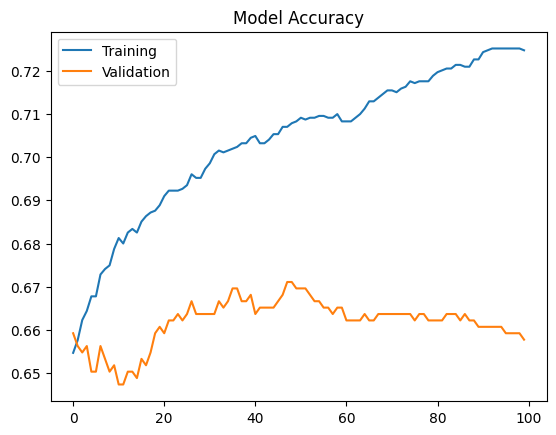

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()